# Explicit time integration basics

_Highlights_
- the basics of time integration with Spitfire

## Introduction

This notebook demonstrates the use of Spitfire's time integration framework, notably the use of explicit Runge-Kutta methods to solve a simple ordinary differential equation,

$$ \frac{\mathrm{d}y}{\mathrm{d}t} = -ky $$

subject to initial condition $y(0) = y_0$ with real coefficient $k>0$.

For now we solve this problem with two well-known methods provided out of the box by Spitfire and observe solutions and numerical errors.

## Solving with Forward Euler and RK4

First we import some Spitfire classes for general-purpose time integration:
- `Governor`: A class that drives all the various types of time integration in Spitfire, from the simple Forward Euler method to adaptive time-stepping with high-order implicit Runge-Kutta methods.
- `SaveAllDataToList`: A class used by the governor to save off data during a simulation.
- `FinalTime`: A termination rule used by the governor to stop a simulation at a specified time. Other termination rules such as steady states, numbers of time steps, or custom user-defined rules are supported as well.

And then we import some classes that represent particular explicit methods:
- `ForwardEuler`: [the simplest method of all](https://en.wikipedia.org/wiki/Euler_method)
- `ExplicitRungeKutta4Classical`: [_the_ Runge Kutta method](https://en.wikipedia.org/wiki/Runge–Kutta_methods), a four-stage, fourth-order method

In [1]:
import numpy as np
from spitfire import (Governor, 
                      SaveAllDataToList, 
                      FinalTime, 
                      ForwardEuler, 
                      ExplicitRungeKutta4Classical)

Next we set up some of the problem details, like the time step, $k$ value, final time, and initial condition $y_0$, which you'll note is made as a `NumPy` array.

Here we also make a function that computes the right-hand side of the differential equation given the current time and solution value as inputs.
Any callable object - something that has a `()` operator that takes two arguments, namely the time and the solution state - can be used as the right-hand side operator.

In [2]:
dt = 0.05
tf = 1.0
k = -10.
y0 = np.array([1.])

rhs = lambda t, y: k * y

Now we make a `Governor` instance, set its termination criteria with a `FinalTime` instance, and we make a `SaveAllDataToList` object and connect it to the governor.

The `custom_post_process_step` attribute of the governor is called at the end of each time step, and the `save_data` method simply saves off the solution state and current time to be accessed later.

In [3]:
governor = Governor()
governor.termination_criteria = FinalTime(tf)

data_fe = SaveAllDataToList(initial_solution=y0, initial_time=0.)
governor.custom_post_process_step = data_fe.save_data

And now we solve the problem with the Forward Euler method.
The use of a `float` in the `controller` input tells the governor to simply use a fixed time step.

In [4]:
governor.integrate(right_hand_side=lambda t, y: k * y,
                   initial_condition=y0,
                   controller=dt,
                   method=ForwardEuler())


 2020-03-26 20:10 : Spitfire running case with method: Forward Euler

|number of  | simulation | time step  | diff. eqn. | total cpu  | cput per |
|time steps | time (s)   | size (s)   | |residual| | time (s)   | step (ms)|
---------------------------------------------------------------------------|
| 1         | 5.00e-02   | 5.00e-02   | 1.00e+01   | 1.64e-01   | 1.64e+02 |
| 2         | 1.00e-01   | 5.00e-02   | 5.00e+00   | 1.65e-01   | 8.25e+01 |
| 3         | 1.50e-01   | 5.00e-02   | 2.50e+00   | 1.66e-01   | 5.52e+01 |
| 4         | 2.00e-01   | 5.00e-02   | 1.25e+00   | 1.67e-01   | 4.18e+01 |
| 5         | 2.50e-01   | 5.00e-02   | 6.25e-01   | 1.68e-01   | 3.37e+01 |
| 6         | 3.00e-01   | 5.00e-02   | 3.12e-01   | 1.69e-01   | 2.82e+01 |
| 7         | 3.50e-01   | 5.00e-02   | 1.56e-01   | 1.70e-01   | 2.43e+01 |
| 8         | 4.00e-01   | 5.00e-02   | 7.81e-02   | 1.72e-01   | 2.15e+01 |
| 9         | 4.50e-01   | 5.00e-02   | 3.91e-02   | 1.73e-01   | 1.92e+01 |
-----

({'time steps': 20,
  'simulation time': array(1.),
  'nonlinear iter': 'n/a',
  'linear iter': 'n/a',
  'Jacobian setups': 0,
  'total cpu time (s)': 0.18310299701988697},
 array([9.53674316e-07]),
 array(1.),
 0.05)

Take a moment to check out the logged output during the simulation and the output from the `integrate` method.

By default a `Governor` instance will write out some information about the simulation at every time step, and after it completes it will provide a brief summary. For this simple case this output is largely unnecessary, but it can be very helpful in more complicated cases.

The output of the `integrate` method, shown above by Jupyter because we didn't capture it in a variable, is a dictionary of run statistics similar to what is shown in the logged output, the final solution state ($y(t_f)$), the final solution time, and the final time step size. Note that if we want to plot $y$ over $t$, as we do below, we have to have set up the `custom_post_process_step` on the `Governor` instance to retain the data over time.

Below we show how to do this and compare the numerical solution to the exact solution:

<IPython.core.display.Javascript object>


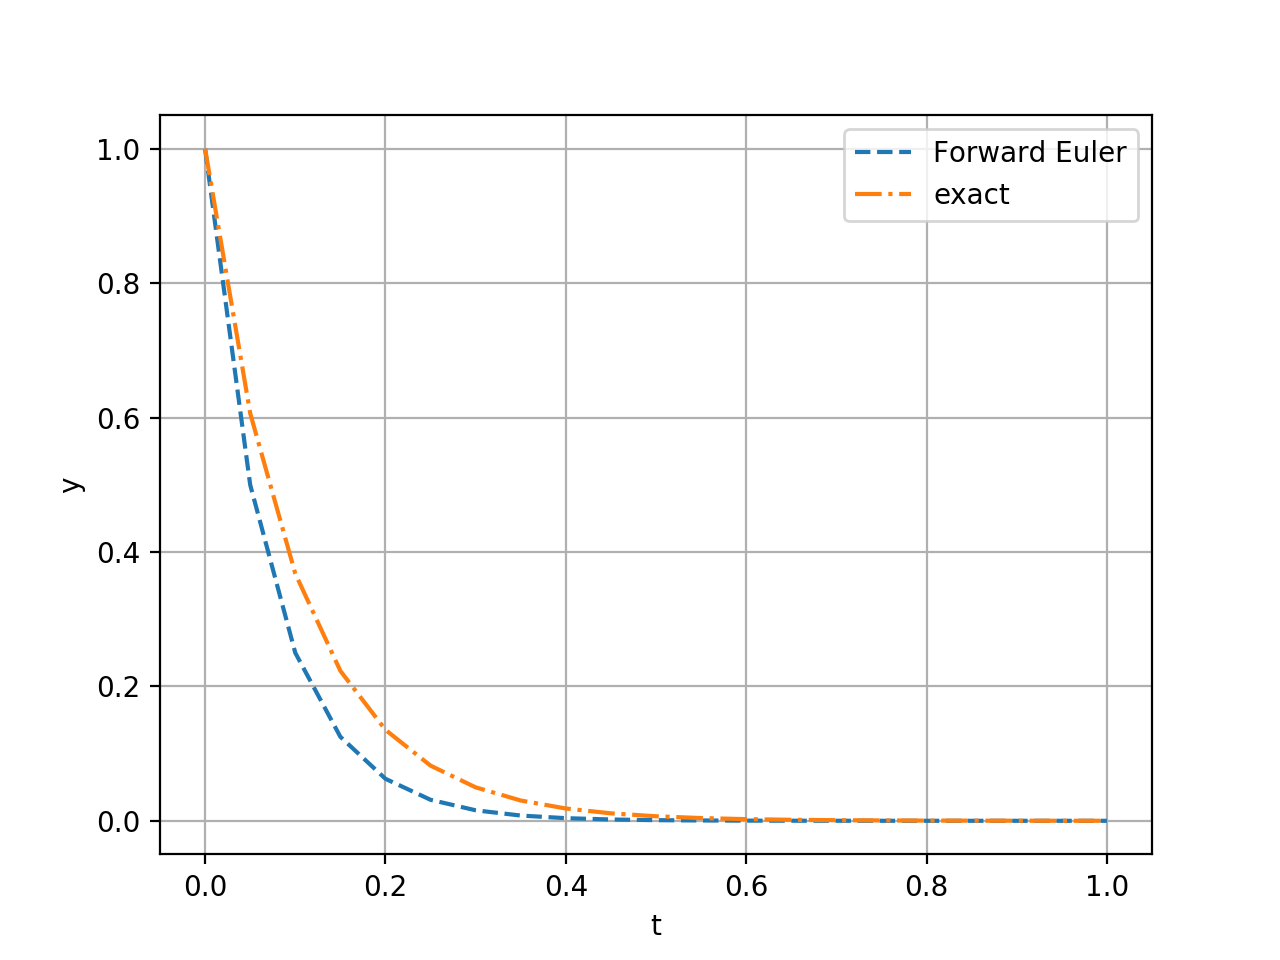

In [5]:
import matplotlib.pyplot as plt
%matplotlib notebook

y_exact = y0 * np.exp(k * data_fe.t_list)

plt.plot(data_fe.t_list, data_fe.solution_list, '--', label='Forward Euler')
plt.plot(data_fe.t_list, y_exact, '-.', label='exact')

plt.xlabel('t')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid()
plt.show()

Next we solve the problem with the fourth-order Runge-Kutta method, using a new `SaveAllDataToList` object to save the data.

Note that we also prevent the logged output from being written to the screen, by setting the `do_logging` attribute on the governor to `False`.

Following the solution we plot the computed solution over time.

<IPython.core.display.Javascript object>


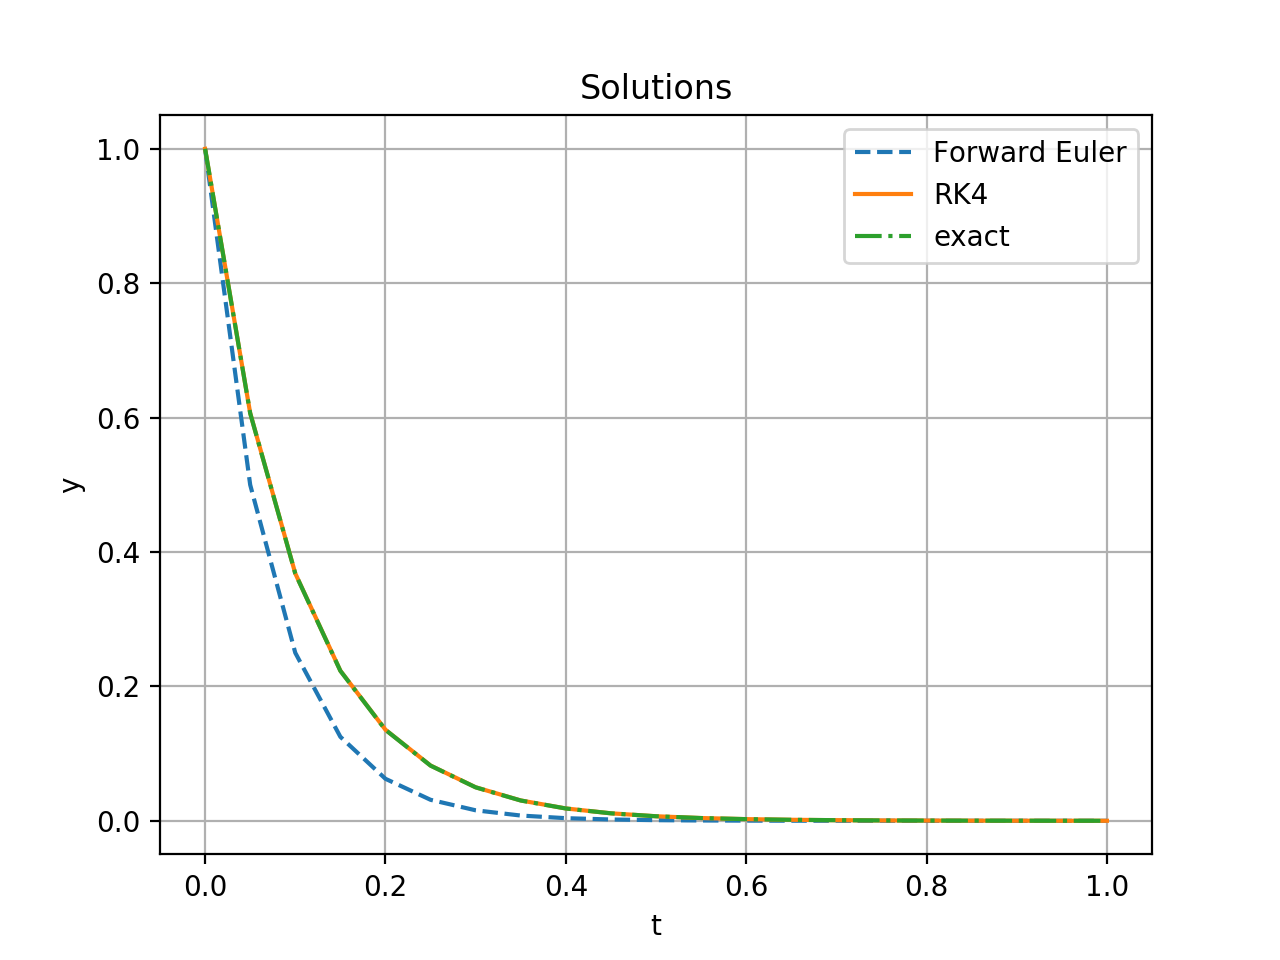

In [7]:
governor.do_logging = False

data_rk4 = SaveAllDataToList(initial_solution=y0, initial_time=0.)
governor.custom_post_process_step = data_rk4.save_data

governor.integrate(right_hand_side=rhs,
                   initial_condition=y0,
                   controller=dt,
                   method=ExplicitRungeKutta4Classical())

%matplotlib notebook
plt.plot(data_fe.t_list, data_fe.solution_list, '--', label='Forward Euler')
plt.plot(data_rk4.t_list, data_rk4.solution_list, '-', label='RK4')
plt.plot(data_fe.t_list, y_exact, '-.', label='exact')

plt.title('Solutions')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid()
plt.show()

Visual inspection alone shows how much more accurate the RK4 method is than Forward Euler for the same size of time step.
We can also plot the errors of the numerical solvers over time to make the point quantitatively.
The plot shows that peak errors between the two methods differ by several orders of magnitude.

<IPython.core.display.Javascript object>


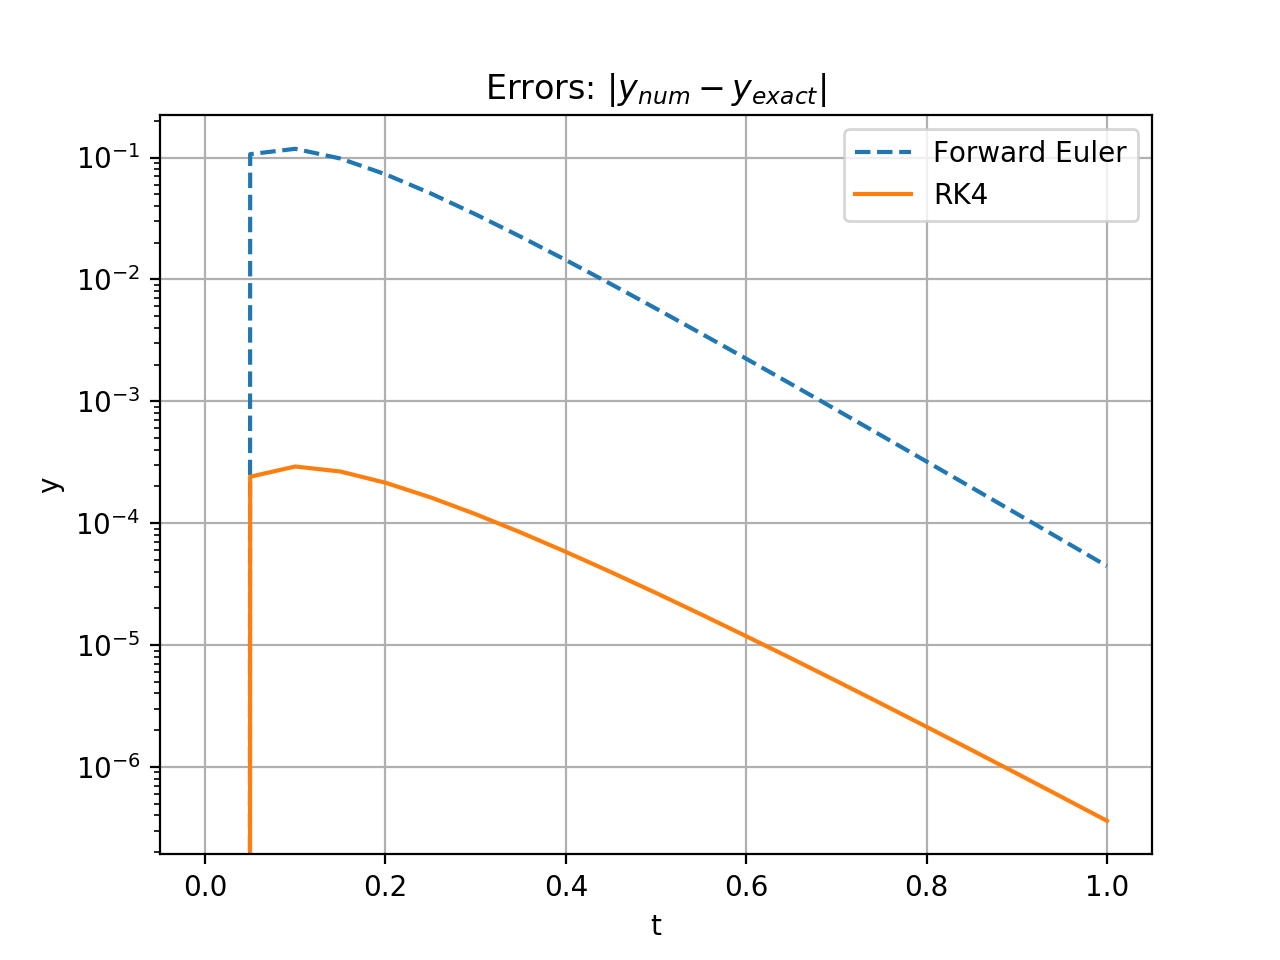

In [8]:
%matplotlib notebook
plt.title('Errors: $|y_{num} - y_{exact}|$')
plt.semilogy(data_fe.t_list, np.abs(data_fe.solution_list.ravel() - y_exact), '--', label='Forward Euler')
plt.semilogy(data_rk4.t_list, np.abs(data_rk4.solution_list.ravel() - y_exact), '-', label='RK4')

plt.xlabel('t')
plt.ylabel('y')
plt.legend(loc='best')
plt.grid()
plt.show()

## Conclusions

In this example we've shown how to use two common time-stepping schemes with Spitfire to solve a simple ordinary differential equation. We've covered how to use a `Governor` instance to drive the time-stepping loop, a `FinalTime` instance to terminate integration at a specified simulation time, and a `SaveAllDataToList` instance to save data over the course of the simulation. At this point, this may seem like a lot of "conceptual overhead" just to solve such a simple problem with rather simple time-stepping methods, it enables Spitfire to facilitate much more complex solution techniques that will be covered later.